# The Deployment Environment

This new notebook will represent our deploy environment. We will import PyTorch and some auxillary packages. Note that we cannot load the torchvision package that contains our network architecture, as it is not installed. We wouldn't want this code to float around on all deployment systems anyway.

In [1]:
import torch
import torch.jit as jit
import numpy as np
import PIL.Image
import json

from IPython.display import Image, display

In [2]:
import torchvision

ModuleNotFoundError: No module named 'torchvision'

In [3]:
with open('./imagenet_classes.json', mode='rt') as f:
    CLASS_DICT = json.load(f)
    
IMAGENET_MEAN = np.array([[[0.485, 0.456, 0.406]]], dtype=np.float32)
IMAGENET_STD = np.array([[[0.229, 0.224, 0.225]]], dtype=np.float32)

def predict_imagenet(net, image_file):
    # Load image and resize
    image = PIL.Image.open(image_file).resize((244, 244))
    # Convert to numpy and normalize
    image = np.array(image, dtype=np.float32) / 255.
    image = (image - IMAGENET_MEAN) / IMAGENET_STD
    # Convert to PyTorch and make channel first
    image = torch.as_tensor(image).unsqueeze(0).permute(0, 3, 1, 2)
    # Predict top class
    logits = net(image)
    class_idx = logits.squeeze(0).argmax().item()
    # Output predictions
    print('It is a %s!' % CLASS_DICT[str(class_idx)])
    display(Image(filename=image_file))

# Minimize Dependencies

Here we define a simple deployment function, which will use our model to predict the class of an image.

So, let's try to load the models we saved earlier our clean environment one by one. We will first try to load the _whole pickled model_. Pickle will try to import the torchvision module to reinstanciate the model object and we will get a nice ModuleNotFoundError, as it is not installed.

In [4]:
# Try to load the whole pickled module
net = torch.load('untraced_model.pth')
print(net)

ModuleNotFoundError: No module named 'torchvision'

Now try the version where we only _saved the state dict._ While it loads without problem, we still only have the parameters of the model. Without the code from torchvision we cannot reinstanciate the model object.

In [5]:
net = torch.load('state_dict_model.pth')
print(net)

OrderedDict([('features.0.weight', tensor([[[[ 1.1864e-01,  9.4069e-02,  9.5435e-02,  ...,  5.5822e-02,
            2.1575e-02,  4.9963e-02],
          [ 7.4882e-02,  3.8940e-02,  5.2979e-02,  ...,  2.5709e-02,
           -1.1299e-02,  4.1590e-03],
          [ 7.5425e-02,  3.8779e-02,  5.4930e-02,  ...,  4.3596e-02,
            1.0225e-02,  1.3251e-02],
          ...,
          [ 9.3155e-02,  1.0374e-01,  6.7547e-02,  ..., -2.0277e-01,
           -1.2839e-01, -1.1220e-01],
          [ 4.3544e-02,  6.4916e-02,  3.6164e-02,  ..., -2.0248e-01,
           -1.1376e-01, -1.0719e-01],
          [ 4.7369e-02,  6.2543e-02,  2.4758e-02,  ..., -1.1844e-01,
           -9.5567e-02, -8.3890e-02]],

         [[-7.2634e-02, -5.7996e-02, -8.0661e-02,  ..., -6.0304e-04,
           -2.5309e-02,  2.5471e-02],
          [-6.9042e-02, -6.7562e-02, -7.6367e-02,  ..., -3.9616e-03,
           -3.0402e-02,  1.0477e-02],
          [-9.9517e-02, -8.5592e-02, -1.0521e-01,  ..., -2.6587e-02,
           -2.2777e-02,

The third method, _exporting to ONNX,_ fails in an unexpected way. There is simply no import function for ONNX models in PyTorch. We can get the model out of the framework, but not back in.

In [6]:
net = torch.onnx...  # Well, there is no import function here...

SyntaxError: invalid syntax (<ipython-input-6-77f83f3d2aea>, line 1)

At last we will try load the _traced network_ from disk. This works flawlessly. One point to notice: the weights are mapped the CPU and not to the device saved from. This behaviour is different from torch.load().

In [7]:
net = jit.load('traced_model.pth')

It is a Persian cat!


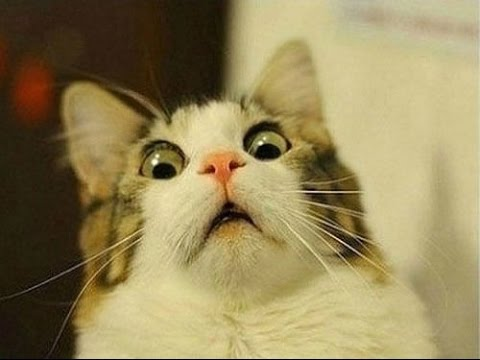

https://i.ytimg.com/vi/2fb-g_V-UT4/hqdefault.jpg


In [8]:
predict_imagenet(net, './whats_this.jpg')
print('https://i.ytimg.com/vi/2fb-g_V-UT4/hqdefault.jpg')

# Even Less Dependencies: Using the Model in C++

To load our traced model into a C++ application, we will use the code below. It is a minimal, compilable example of what we want to do. We read the path to the model from the commandline arguments and instanciate a new _jit::script::Module_. Then we load it with the _jit::load_ function, which is äquivalent to the Python one. Any error while loading is caught.

In [9]:
#include <torch/script.h>
#include <memory>

int main(int argc, const char* argv[]) {
  if (argc != 2) {
    std::cerr << "usage: example_app <path_to_exported_script_module>\n";
    return -1;
  }

  torch::jit::script::Module module;
  try {
    module = torch::jit::load(argv[1]);
  }
  catch (const c10::Error& e) {
    std::cerr << "error loading the model\n";
    return -1;
  }

  std::cout << "ok\n";
    
  ...
    
}

SyntaxError: invalid syntax (<ipython-input-9-995ae6259dd3>, line 4)

Using the forward pass of our model is similar to Python, too. We build an input vector of tensors and pass it to the network. The output is saved to a new tensor object. Different to Python is, that the tensor class lives in the ATen namespace, _at_. Furthermore the module does not accept and output tensors directly. Instead it uses _jit::IValue_ objects. The input tensor is automatically cast to an _IValue_ on assignment to the input vector and the module output is explicitly cast by the _toTensor_ function

In [10]:
...

std::vector<torch::jit::IValue> inputs;
inputs.push_back(torch::randn({1, 3, 224, 224}));
at::Tensor output;

output = module.forward(inputs).toTensor();

...

SyntaxError: invalid syntax (<ipython-input-10-d5461a7b8c4b>, line 3)

### Minimize Dependencies ✅

Our first promise was fulfilled. The model traced by the JIT is only dependend on PyTorch itself. Any custom code dependency is resolved automatically.

# Hiding Code

So what about hiding code, next? When printing the network, we can see that submodules have no name and no parameters displayed. Other than from the untraced network print, we cannot infer anything from this print.

In [11]:
print(net)

ScriptModule(
  (features): ScriptModule(
    (0): ScriptModule()
    (1): ScriptModule()
    (2): ScriptModule()
    (3): ScriptModule()
    (4): ScriptModule()
    (5): ScriptModule()
    (6): ScriptModule()
    (7): ScriptModule()
    (8): ScriptModule()
    (9): ScriptModule()
    (10): ScriptModule()
    (11): ScriptModule()
    (12): ScriptModule()
  )
  (avgpool): ScriptModule()
  (classifier): ScriptModule(
    (0): ScriptModule()
    (1): ScriptModule()
    (2): ScriptModule()
    (3): ScriptModule()
    (4): ScriptModule()
    (5): ScriptModule()
    (6): ScriptModule()
  )
)


But let's have a look at the object to see how much we can find out. The dir() function reveals all python functions of an object. Since version 1.2 the ScriptModule has all the function of a normal nn.Module. Before the dir() function failed actually. One function is most interesting: code. Could this show us the code of our network?

In [12]:
[f for f in dir(net) if not f.startswith('_')]

['add_module',
 'apply',
 'avgpool',
 'buffers',
 'children',
 'classifier',
 'code',
 'copy',
 'cpu',
 'cuda',
 'define',
 'double',
 'dump_patches',
 'eval',
 'extra_repr',
 'features',
 'float',
 'forward',
 'forward',
 'forward',
 'get_debug_state',
 'graph',
 'graph_for',
 'half',
 'load_state_dict',
 'modules',
 'named_buffers',
 'named_children',
 'named_modules',
 'named_parameters',
 'parameters',
 'register_backward_hook',
 'register_buffer',
 'register_forward_hook',
 'register_forward_pre_hook',
 'register_parameter',
 'requires_grad_',
 'save',
 'save_to_buffer',
 'share_memory',
 'state_dict',
 'to',
 'train',
 'training',
 'type',
 'zero_grad']

There it is. Now we can have a look at our architecture in TorchScript. Not hidden that much.

In [13]:
print(net.code)

def forward(self,
    input: Tensor) -> Tensor:
  _0 = self.features
  _1 = getattr(_0, "0")
  weight = _1.weight
  _2 = _1.bias
  _3 = getattr(_0, "3")
  weight0 = _3.weight
  _4 = _3.bias
  _5 = getattr(_0, "6")
  weight1 = _5.weight
  _6 = _5.bias
  _7 = getattr(_0, "8")
  weight2 = _7.weight
  _8 = _7.bias
  _9 = getattr(_0, "10")
  weight3 = _9.weight
  _10 = _9.bias
  _11 = self.classifier
  _12 = getattr(_11, "1")
  weight4 = _12.weight
  bias = _12.bias
  _13 = getattr(_11, "4")
  weight5 = _13.weight
  bias0 = _13.bias
  _14 = getattr(_11, "6")
  weight6 = _14.weight
  bias1 = _14.bias
  input0 = torch._convolution(input, weight, _2, [4, 4], [2, 2], [1, 1], False, [0, 0], 1, False, False, True)
  input1 = torch.relu_(input0)
  input2 = torch.max_pool2d(input1, [3, 3], [2, 2], [0, 0], [1, 1], False)
  input3 = torch._convolution(input2, weight0, _4, [1, 1], [2, 2], [1, 1], False, [0, 0], 1, False, False, True)
  input4 = torch.relu_(input3)
  input5 = torch.max_pool2d(input4, [

Now we only need to find the weights, so let's look at the member variables of the first module. The var() function will expose them for us. We can see a lot of dictionaries, of which only five seem to hold something. We will check the one named parameters.

In [14]:
vars(net.features._modules['0'])

{'_c': <torch._C.ScriptModule at 0x1ee3e8bd6c0>,
 '_backend': <torch.nn.backends.thnn.THNNFunctionBackend at 0x1ee3e429b70>,
 '_parameters': <torch.jit.OrderedParameterDict at 0x1ee3e8bdbe0>,
 '_buffers': <torch.jit.OrderedBufferDict at 0x1ee3e8bdb38>,
 '_backward_hooks': OrderedDict(),
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_modules': <torch.jit.OrderedModuleDict at 0x1ee3e8bdac8>,
 'training': True}

This dictionary seems to hold the weights and the bias of the module.

In [15]:
print(net.features._modules['0']._parameters.keys())

['weight', 'bias']


From the shape of the weights we can conclude that this module is a convolution layer with a 11x11 kernel, 3 input channels and 64 output channels. This matches with the info we got from the TorchScript code.

In [16]:
print(net.features._modules['0']._parameters['weight'].shape)

torch.Size([64, 3, 11, 11])


### Hide Code 😐

In conclusion, we can say that the JIT hides the code of your net better than exporting it conventionally. It is still no problem for anyone with a Python interpreter to retrieve it, though.

# Back to our training system!